In [1]:
from torchvision import datasets, transforms

### 数据增强

In [2]:
train_trans = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.RandomResizedCrop(96, scale=(0.6, 1.0), ratio=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0),
    transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [3]:
test_trans = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [4]:
train_dir = r'../data/4weather_classification/train'
test_dir = r'../data/4weather_classification/test'

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_trans)
test_dataset = datasets.ImageFolder(test_dir, transform=test_trans)

In [6]:
from torch.utils.data import DataLoader

In [7]:
BATCHSIZE = 16
train_iter = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=BATCHSIZE)

In [8]:
import torchvision
from torch import nn

In [9]:
model = torchvision.models.resnet101(pretrained=True)

In [10]:
for p in model.parameters():
    p.requires_grad = False

In [11]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 4)

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
import torch
from torch.optim import lr_scheduler

In [14]:
def fit(epoch, model, train_iter, test_iter, loss, opt, device, scheduler):

    model.to(device)

    train_correct = 0
    train_total = 0
    train_running_loss = 0

    model.train()
    
    for x, y in train_iter:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        opt.zero_grad()
        l = loss(y_hat, y)
        l.backward()
        opt.step()
        with torch.no_grad():
            y_hat = torch.argmax(y_hat, dim=1)
            train_correct += (y_hat == y).sum().item()
            train_total += y.size(0)
            train_running_loss += l.item()
    
    scheduler.step()
    train_loss = train_running_loss / len(train_iter.dataset)
    train_acc = train_correct / train_total

    test_correct = 0
    test_total = 0
    test_running_loss = 0

    model.eval()

    with torch.no_grad():
        for x, y in test_iter:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            l = loss(y_hat, y)
            y_hat = torch.argmax(y_hat, dim=1)
            test_correct += (y_hat == y).sum().item()
            test_total += y.size(0)
            test_running_loss += l.item()
    test_loss = test_running_loss / len(test_iter.dataset)
    test_acc = test_correct / test_total

    print(
        'epoch: ', epoch,
        'train_loss: ', round(train_loss, 3),
        'train_accura', round(train_acc * 100, 3), '%',
        'test_loss: ', round(test_loss, 3),
        'test_accura', round(test_acc * 100, 3), '%',
    )

    return train_loss, train_acc, test_loss, test_acc

In [15]:
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=1)

In [16]:
num_epochs = 50

all_train_loss = []
all_train_acc = []
all_test_loss = []
all_test_acc = []

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

for epoch in range(num_epochs):
    train_loss, train_acc, test_loss, test_acc = fit(
        epoch, model, train_iter, test_iter, loss, opt, device, exp_lr_scheduler
    )
    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)
    all_test_loss.append(test_loss)
    all_test_acc.append(test_acc)

epoch:  0 train_loss:  0.051 train_accura 69.0 % test_loss:  0.027 test_accura 88.0 %
epoch:  1 train_loss:  0.026 train_accura 86.111 % test_loss:  0.018 test_accura 90.222 %
epoch:  2 train_loss:  0.021 train_accura 89.333 % test_loss:  0.018 test_accura 91.111 %
epoch:  3 train_loss:  0.022 train_accura 87.556 % test_loss:  0.017 test_accura 90.222 %
epoch:  4 train_loss:  0.018 train_accura 90.333 % test_loss:  0.015 test_accura 91.111 %
epoch:  5 train_loss:  0.016 train_accura 91.889 % test_loss:  0.02 test_accura 89.333 %
epoch:  6 train_loss:  0.015 train_accura 91.333 % test_loss:  0.017 test_accura 91.556 %
epoch:  7 train_loss:  0.015 train_accura 91.222 % test_loss:  0.017 test_accura 90.667 %
epoch:  8 train_loss:  0.016 train_accura 91.333 % test_loss:  0.017 test_accura 91.556 %
epoch:  9 train_loss:  0.015 train_accura 91.889 % test_loss:  0.015 test_accura 91.556 %
epoch:  10 train_loss:  0.013 train_accura 92.222 % test_loss:  0.013 test_accura 92.0 %
epoch:  11 train

In [17]:
import matplotlib.pyplot as plt

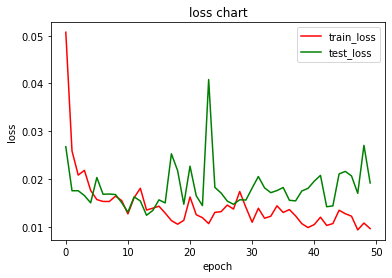

In [18]:
plt.title('loss chart')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(all_train_loss, color='r', label='train_loss')
plt.plot(all_test_loss, color='g', label='test_loss')
plt.legend()

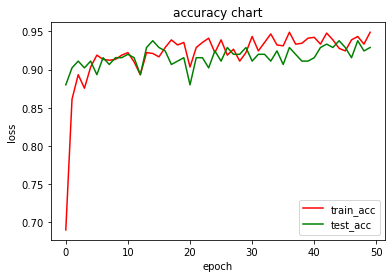

In [19]:
plt.title('accuracy chart')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(all_train_acc, color='r', label='train_acc')
plt.plot(all_test_acc, color='g', label='test_acc')
plt.legend()

In [20]:
PATH = r'../model/resnet101_4weathers.pth'
torch.save(model.state_dict, PATH)